- Pick Best Portfolio (best means highest sharpe ratio here)
- Assume this is our portfolio right now
- Use Geometric Brownian Motion to calculate portfolio value in n years
- See how we performed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from cvxopt import matrix, solvers

In [3]:
def get_asset_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

In [4]:
tickers = ['AAPL', 'TXNM', 'MSFT', 'JNJ', 'CL', 'NVDA']
start_date = '2020-01-01'
end_date = '2023-01-01'

In [5]:
data = get_asset_data(tickers, start_date, end_date)
data.dropna(inplace=True)

[*********************100%***********************]  6 of 6 completed


In [13]:
returns = data.pct_change().dropna()
expected_returns = returns.mean() * 252
volatilities = returns.std() * np.sqrt(252)
initial_prices = data.iloc[-1].values  # Latest closing prices
cov_matrix = returns.cov() * 252

In [14]:
# Geometric Brownian Motion (GBM)
def gbm_simulation(S0, mu, sigma, T, steps, n_sim):
    dt = T / steps  # time increment
    prices = np.zeros((steps + 1, n_sim))
    prices[0] = S0
    
    for t in range(1, steps + 1):
        z = np.random.standard_normal(n_sim)
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return prices

In [15]:
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

In [16]:
def stochastic_portfolio_optimization(expected_returns, cov_matrix, num_simulations=1000):
    num_assets = len(expected_returns)
    results = np.zeros((3, num_simulations))  # Store return, volatility, Sharpe ratio
    weights_record = []

    for i in range(num_simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(weights, expected_returns, cov_matrix)

        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = sharpe_ratio
        weights_record.append(weights)

    max_sharpe_idx = np.argmax(results[2])
    best_weights = weights_record[max_sharpe_idx]
    
    return best_weights, results[:, max_sharpe_idx]

In [17]:
best_weights, best_results = stochastic_portfolio_optimization(expected_returns, cov_matrix)

weights_df = pd.DataFrame(best_weights, index=tickers, columns=["Optimal Weight"])

print(f"Expected Return: {best_results[0] * 100:.2f}%")
print(f"Risk (Volatility): {best_results[1] * 100:.2f}%")
print(f"Sharpe Ratio: {best_results[2]:.2f}")

Expected Return: 28.41%
Risk (Volatility): 33.40%
Sharpe Ratio: 0.85


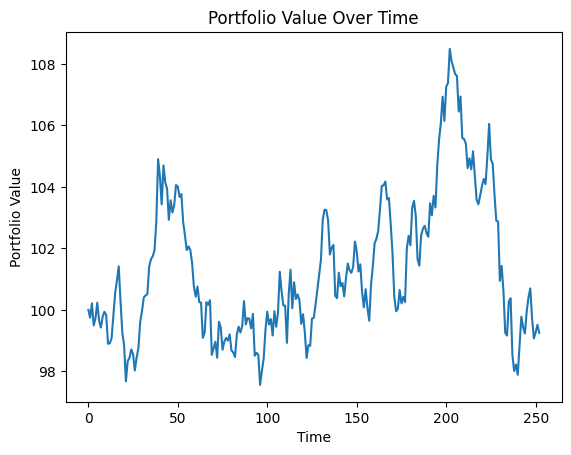

In [18]:
import matplotlib.pyplot as plt

def backtest_portfolio(prices, weights):
    portfolio_values = np.dot(prices, weights)
    plt.plot(portfolio_values)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.show()


T = 5
steps = 252  # Daily steps (252 trading days)

# Simulate the prices for the entire portfolio
simulated_prices = gbm_simulation(initial_prices, expected_returns.values, volatilities.values, T, steps, len(tickers))

simulated_prices_df = pd.DataFrame(simulated_prices, columns=tickers)

backtest_portfolio(prices, best_weights)